In [33]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
import random
from scipy.special import logsumexp
import scipy as sp
from tqdm.auto import tqdm
from mpl_toolkits import mplot3d
from scipy.optimize import minimize, NonlinearConstraint
from psf_functions import *
from tabulate import tabulate
import scipy.integrate as integrate
from scipy import stats
#from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import math
#from scipy.interpolate import UnivariateSpline
#from tqdm import tqdm

In [7]:
#SNR on g2 code doesn't work yet
matplotlib.rcParams['figure.figsize'] = (5, 5)

In [8]:
#global variables
ROI_radius = 1.1
MLE_samples = 10

In [9]:
def normalize_mat(M):
    temp = np.max(M)
    return M/temp

def entropy(matrix):
    flattened_matrix = matrix.flatten()
    probabilities = flattened_matrix / np.sum(flattened_matrix)
    non_zero_probabilities = probabilities[probabilities > 0]
    entropy_value = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))
    return entropy_value

In [10]:
class emitter_env:
    def __init__(self, bkg, noise, num_emitter=1, gap = 0, dim = 2):
        #dim is dimesion of space. 2D or 3D
        self.num_emitter = num_emitter #number of emitters
        self.gap = gap
        self.radius = ROI_radius #radius of ROI
        self.dim = dim #dimension of space. Currently code written for working in 2D only.
        self.bkg = bkg
        self.noise = noise #1/SNR
        self.mu_list, self.sigma_list = self.gen_emitter_data() 
        
        
    def gen_emitter_data(self):
        r = self.gap/2
        theta_list = np.linspace(0,2*np.pi, self.num_emitter+1)
        mu_list = np.zeros((self.num_emitter,self.dim))
        sigma_list = np.ones((self.num_emitter,self.dim))
        for i in range(self.num_emitter):
            mu_list[i][0] = r*np.cos(theta_list[i])
            mu_list[i][1] = r*np.sin(theta_list[i]) 
        return mu_list, sigma_list

    
    def gen_emitter_data_rnd(self):
        #only works for two emitters
        if self.num_emitter !=2:
             raise ValueError("Code only available 2 emitters")
        if self.gap ==0:
            raise ValueError("gap is set to zero")
        r_max = self.radius #size of ROI
        d = self.gap
        mu_list = np.zeros((self.num_emitter,self.dim))
        sigma_list = np.ones((self.num_emitter,self.dim))
        #randomly initialize first emitter in ROI
        theta1 = 2*np.pi*random.random()
        r1 = (r_max-0.1)*np.sqrt(random.random())
        mu_list[0][0] = r1*np.cos(theta1)
        mu_list[0][1] = r1*np.sin(theta1)
        
        #initialize second emitter
        for i in range(10000):
            theta = 2*np.pi*random.random()
            x_temp = d*np.cos(theta) + mu_list[0][0]
            y_temp = d*np.sin(theta) + mu_list[0][1]
            #check if 2nd emitter is within ROI
            if np.sqrt(x_temp**2 + y_temp**2) < r_max:
                mu_list[1][0] = x_temp
                mu_list[1][1] = y_temp
                break
        if mu_list[1][0] == mu_list[1][0] == 0:
            r = np.absolute(d-r1)
            theta = theta1+np.pi
            mu_list[1][0] = r*np.cos(theta)
            mu_list[1][1] = r*np.sin(theta)
            
        return mu_list, sigma_list
        
def image_psf(env, max_axis=ROI_radius*1.1,res = 100, psftype = 0, normalize=1, plot =0):
    if psftype ==0:
        psffn = psf_intensity
        data_type = "intenisty"
    elif psftype == 1:
        psffn = psf_g2
        data_type = "g2"
    else:
        raise ValueError("Code only available for 0 and 1")
    
    X_temp = np.linspace(-max_axis,max_axis,res)
    Y_temp = np.linspace(-max_axis,max_axis,res)
    pixel_data = np.zeros((len(X_temp),len(Y_temp)))
    for i in range(len(X_temp)):
        for j in range(len(Y_temp)):
            pixel_data[i][j] = psffn(np.array([X_temp[i],Y_temp[j]]),env.mu_list,env.sigma_list,env.bkg,env.noise,normalize)
    pixel_data= np.transpose(pixel_data)
#     if normalize:
#         pixel_data = normalize_mat(pixel_data)
    if plot==1:
        plt.title(data_type + " psf of Emitter"+"\n SNR = "+str(round(1/env.noise,2)))
        plt.xlabel("x axis")
        plt.ylabel("y axis")
        plt.contourf(X_temp, Y_temp, pixel_data, 100)
        for mu in env.mu_list:
            plt.scatter(mu[0],mu[1], marker ='x', color = "red")
        # Generate data points to plot the circle
        theta = np.linspace(0, 2 * np.pi, 100)
        x_circle = env.radius * np.cos(theta)
        y_circle = env.radius * np.sin(theta)
        plt.plot(x_circle, y_circle, '--', color='aqua', alpha = 0.6)
    elif plot==2:
        #slice of the image at a particular y
        plt.plot(X_temp, pixel_data[int(res/2)]) 
    return pixel_data, X_temp, Y_temp


In [67]:
def sample_fn(n_sample, exp_radius):
    #currently doesn't use n_sample as input
    N = 6
    grid_arr = np.linspace(-exp_radius,exp_radius,N)
    points = []
    for i in range(N):
        for j in range(N):
            if np.linalg.norm([grid_arr[i],grid_arr[j]]) <= exp_radius:
                points.append([grid_arr[i],grid_arr[j]])
    return np.array(points)

def groundtruth_fn(env,points, psftype=0, normalize = 1):
    #points is array of type [[x,y],[x,y],..]
    if psftype ==0:
        psffn = psf_intensity
        data_type = "intenisty"
    elif psftype == 1:
        psffn = psf_g2
        data_type = "g2"
    else:
        raise ValueError("Code only available for 0 and 1")
        
    groundtruth_data = []
    for p in points:
        groundtruth_data.append(psffn(p,env.mu_list,env.sigma_list,env.bkg,env.noise,normalize))
    
    return groundtruth_data

def calc_guess(x,y,z,r):
    z = z/np.linalg.norm(z)
    x_guess = np.array(x).reshape(-1,1) 
    y_guess = np.array(y)
    regr = LinearRegression()
    regr.fit(x_guess,y_guess,z**50)
    #plt.plot([-1,1],regr.predict(np.array([-1,1]).reshape(-1,1)),'--',color = 'orange')
#     #scale points according to their z value
#     x_line = [x[i]*z[i] for i in range(len(x))]
#     y_line = [y[i]*z[i] for i in range(len(y))]
    m, b = np.polyfit([-1,0,1], regr.predict(np.array([-1,0,1]).reshape(-1,1)), 1)
    x_intercept = np.array([(-b*m+np.sqrt((m*r)**2 + r**2-b**2))/(m**2+1),(-b*m-np.sqrt((m*r)**2 + r**2-b**2))/(m**2+1)])
    x_intercept = np.array([np.sign(x)*(np.absolute(x)-0.1) for x in x_intercept])
    y_intercept = x_intercept*m+b
    return x_intercept,y_intercept

#MLE fit
def MLE_Norm_int(parameters,*args):
    # extract parameters
    #assumes background has already been substracted
    mu1x,mu1y,mu2x,mu2y,std_dev = parameters
    x,y,ground_data,lamd,bkg = args #no use of lamd
    # predict the output
    pred = psf_intensity([x,y],[[mu1x,mu1y],[mu2x,mu2y]],np.ones((2,2)),bkg,noise=0,normalize =1)
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(ground_data, pred, std_dev))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL

def MLE_Norm_comb(parameters,*args):
    # extract parameters
    #assumes background has already been substracted
    mu1x,mu1y,mu2x,mu2y,std_dev = parameters
    x,y,ground_data,lamd,bkg = args
    # predict the output
    X = [x,y]
    mu_list = [[mu1x,mu1y],[mu2x,mu2y]]
    sigma_list = np.ones((2,2))
    pred = psf_intensity(X,mu_list,sigma_list,bkg,0,1)+lamd*psf_g2(X,mu_list,sigma_list,bkg,0,1)
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(ground_data, pred, std_dev))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL

def lambda_val(env):
    #code to give out lambda given environment parameters
    return 1 #lambda

def mle_estimation(env,num_samples = MLE_samples,data_type=0):
    #num_samples is number of samples to take of ground truth to run MLE estimation
    if data_type==0:
        MLE_Norm=MLE_Norm_int
    elif data_type==1:
        MLE_Norm=MLE_Norm_comb
    #sample
    sample_coordinates = sample_fn(num_samples, env.radius)
    x = [p[0] for p in sample_coordinates]
    y = [p[1] for p in sample_coordinates]
    gt_data = groundtruth_fn(env,sample_coordinates)
    #cal initial guess
    x_inp,y_inp = calc_guess(x,y,gt_data,env.radius)
    guess = np.array([x_inp[0],y_inp[0],x_inp[1],y_inp[1],np.std(gt_data)]) #initial estimate assuming 2 emitters
    #lambda value
    lamd = lambda_val()
    #set up constraints
    def fn1(x):
        return env.radius - np.linalg.norm([x[0],x[1]])
    def fn2(x):
        return env.radius - np.linalg.norm([x[2],x[3]])
    nlc1 = {'type': 'ineq', 'fun': fn1}
    nlc2 = {'type': 'ineq', 'fun': fn2}
    #run mle
    results = minimize(MLE_Norm, guess,args=(x,y,gt_data,lamd,env.bkg,),constraints=[nlc1,nlc2] )#method = 'Nelder-Mead'
    pos_arr = results.x[:4]
    return results

In [ ]:
#optimization using gradient descent
def grad_ascent(env):
    #inputs as emitter environment "env"
    #output array pos_arr = [x1,y1,x2,y2] i.e our estimation of both emitter position
    return pos_arr 

In [12]:
#eperimetn functions
def cal_precision(mu_list,results_list):
    #separate coordinates into two bins depending on which emitter they are closer to
    em1 = mu_list[0]
    em2 = mu_list[1]
    bin1 = [] # closer to mu_list[0]
    bin2 = [] # closer to mu_list[1]
    for r in results_list:
        X1 = np.array([r.x[0],r.x[1]])
        X2 = np.array([r.x[2],r.x[3]])
        if np.linalg.norm(X1-em1) < np.linalg.norm(X1-em2):
            bin1.append(X1)
            bin2.append(X2)
        else:
            bin1.append(X2)
            bin2.append(X1)
    #calculate precision for each bin
    center1 = 0
    for b in bin1:
        center1 = center1+b
    center1 = center1/len(bin1)
    center2 = 0
    for b in bin2:
        center2 = center2+b
    center2 = center2/len(bin2)
    std_dev1 = 0
    for b in bin1:
        std_dev1 = std_dev1 + np.linalg.norm(bin1-center1)
    std_dev1 = std_dev1/len(bin1)
    std_dev2 = 0
    for b in bin1:
        std_dev2 = std_dev2 + np.linalg.norm(bin2-center2)
    std_dev2 = std_dev2/len(bin2)
    
    precision = (std_dev1+std_dev2)/2
    return precision, bin1,bin2

def precision_exp(SBR, SNR=0, gap_list=np.linspace(0.5,1.5,10),iter_precision = 50, iter_env = 10):
    #generate precision vs distance plot for localization exp
    #gap range is for distance between emitters
    #iter_precision is for number of exp per gap to calculate precision
    #iter_env is number of different env on which precision is calculated and averaged over
    #initialize env with 2 emitters, given SBR and SNR
    env = emitter_env(num_emitter = 2, bkg=1/(SBR-1),noise = 0,gap = 0)
    #set distance and run precision experiment
    avg_presvsgap_arr=[]  
    for d in tqdm(gap_list):
        #generate new env with specified gap
        precision_avg=0
        for i in range(iter_env):
            result_arr = []
            env.gap = d
            env.mu_list, env.sigma_list = env.gen_emitter_data_rnd()
            #run iter_precision exp with different sampling each time to ge precision
            for i in range(iter_precision):
                results = mle_estimation(env)
                result_arr.append(results)
            precision = cal_precision(env.mu_list,result_arr)[0]
            precision_avg = precision_avg+precision
        precision_avg = precision_avg/iter_env
        avg_presvsgap_arr.append(precision_avg)
    return avg_presvsgap_arr, gap_list

In [60]:
#experiment parametes
start_bkg = 0.1
start_noise =0.001
env1 = emitter_env(num_emitter = 2, bkg=start_bkg,noise = start_noise,gap = 1)

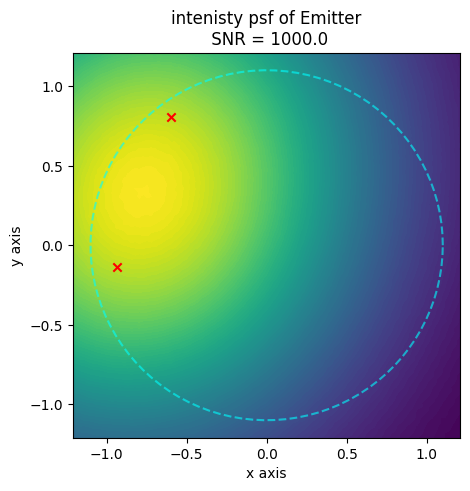

In [61]:
#env1 = emitter_env(num_emitter = 2, bkg=start_bkg,noise = start_noise,gap = 3)
env1.gap = 1
env1.mu_list, env1.sigma_list = env1.gen_emitter_data_rnd()
_ = image_psf(env1,psftype = 0,plot =1)

Text(0, 0.5, 'y axis')

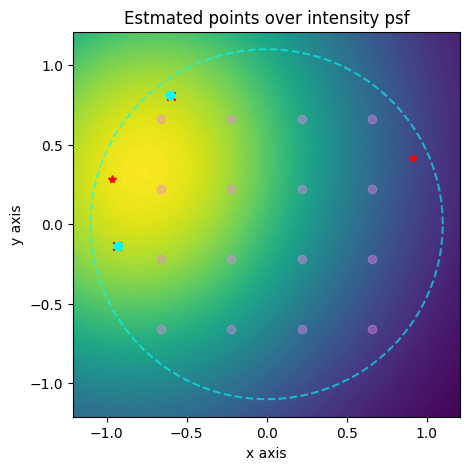

In [70]:
points = sample_fn(10, env1.radius)
image_data,x,y = image_psf(env1,psftype = 0,plot =0)
plt.contourf(x, y, image_data, 100)
for mu in env1.mu_list:
    plt.scatter(mu[0],mu[1], marker ='x', color = "red")
plt.scatter(*zip(*points), c="violet", alpha = 0.4)
# Generate data points to plot the circle
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = env1.radius * np.cos(theta)
y_circle = env1.radius * np.sin(theta)
plt.plot(x_circle, y_circle, '--', color='aqua', alpha = 0.6)

#cal guess
x_guess = [p[0] for p in points]
y_guess = [p[1] for p in points]
grnd_data = groundtruth_fn(env1,points)
guess_x,guess_y = calc_guess(x_guess,y_guess,grnd_data,env1.radius)
plt.plot(guess_x,guess_y,'*',color='red')

#estimate location
results = mle_estimation(env1) #change to grad_ascent
x_res = [results.x[0],results.x[2]]
y_res = [results.x[1],results.x[3]]
plt.scatter(x_res,y_res, color = 'aqua')

plt.title("Estmated points over intensity psf")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
#test for precision graph
env2 = emitter_env(num_emitter = 2, bkg=0.1,noise = 0)
env2.gap = 1
env2.mu_list, env2.sigma_list = env2.gen_emitter_data_rnd()
#run iter_precision exp with different sampling each time to ge precision
result_arr = []
for i in tqdm(range(20)):
    results = mle_estimation(env2, num_samples = 4)
    result_arr.append(results)
precision,bin1,bin2 = cal_precision(env2.mu_list,result_arr)


image_data,x,y = image_psf(env2,psftype = 0,plot =0)
plt.contourf(x, y, image_data, 100)
# Generate data points to plot the ROI
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = env2.radius * np.cos(theta)
y_circle = env2.radius * np.sin(theta)
plt.plot(x_circle, y_circle, '--', color='aqua', alpha = 0.6)

#plot bins
x1 = [b[0] for b in bin1]
y1 = [b[1] for b in bin1]
x2 = [b[0] for b in bin2]
y2 = [b[1] for b in bin2]
plt.scatter(x1,y1, color = 'aqua')
plt.scatter(x2,y2, color = 'orange')

center1 = 0
for b in bin1:
    center1 = center1+b
center1 = center1/len(bin1)
center2 = 0
for b in bin2:
    center2 = center2+b
center2 = center2/len(bin2)

# plt.scatter(center1[0],center1[1],color='blue')
# plt.scatter(center2[0],center2[1],color='red')

for mu in env2.mu_list:
    plt.scatter(mu[0],mu[1], marker ='x', color = "red")

plt.title("MLE run over intensity psf, precision="+str(round(precision,2)))
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
image_data,x,y = image_psf(env2,psftype = 0,plot =0)
plt.contourf(x, y, image_data, 100)
# Generate data points to plot the ROI
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = env2.radius * np.cos(theta)
y_circle = env2.radius * np.sin(theta)
plt.plot(x_circle, y_circle, '--', color='aqua', alpha = 0.6)

#plot bins
x1 = [b[0] for b in bin1]
y1 = [b[1] for b in bin1]
x2 = [b[0] for b in bin2]
y2 = [b[1] for b in bin2]
plt.scatter(x1,y1, color = 'purple', alpha=0.5)
plt.scatter(x2,y2, color = 'purple',alpha=0.5)

center1 = 0
for b in bin1:
    center1 = center1+b
center1 = center1/len(bin1)
center2 = 0
for b in bin2:
    center2 = center2+b
center2 = center2/len(bin2)

# plt.scatter(center1[0],center1[1],color='blue')
# plt.scatter(center2[0],center2[1],color='red')

for mu in env2.mu_list:
    plt.scatter(mu[0],mu[1], marker ='x', color = "red")

plt.title("MLE run over intensity psf, precision="+str(round(precision,2)))
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
y_prec,x_prec = precision_exp(SBR=10,gap_list = np.linspace(0.1,1,20),iter_precision = 20, iter_env = 10)

In [ ]:
plt.title("Precision vs distance between emitters \n SBR=10, SNR = Infinity")
plt.plot(x_prec,y_prec)
plt.xlabel("distance")
plt.xticks(np.linspace(0.1,1,10))
plt.ylabel("precision")

In [ ]:
SBR_range = np.logspace(2,0,5)
#repeate precision vs gap graph for each SBR
SBR_graph_list = []
for sbr in tqdm(SBR_range):
    SBR_graph_list.append([precision_exp(SBR = sbr)])

In [ ]:
SBR_graph_list[0][0]

In [ ]:
plt.plot(SBR_graph_list[0][0][1],SBR_graph_list[0][0][0])

In [ ]:
np.logspace(2,0,5)

In [ ]:
int_img, xa,ya = image_psf(env1,max_axis = 4,psftype=0,normalize = 0, plot =0)
g2_img, xb,yb = image_psf(env1,max_axis = 4,psftype=1,normalize = 1,plot =0)
plt.plot(xa, int_img[int(len(ya)/2)]-env1.bkg, label= 'intensity')
plt.plot(xb, g2_img[int(len(yb)/2)], label = 'g2')
plt.plot([-start_radius]*10,np.linspace(0,1,10), "--", color='aqua', label = "starting position")
plt.plot([start_radius]*10,np.linspace(0,1,10), "--", color='aqua')
plt.legend()
plt.title("1D slice of psf plots for g2 and intensity"+ "\n bkg ="+str(start_bkg))# + ", SNR="+str(1/start_noise))
plt.xlabel("x axis")

In [ ]:
arr = np.absolute(g2_img[int(len(yb)/2)]-0.5)
arr1 = arr[:int(len(xb)/2)]
arr2 = arr[int(len(xb)/2):]
x1 = arr1.argmin()
x2 = arr2.argmin()
temp= abs(xb[x1]-xb[int(len(xb)/2)+x2])

In [ ]:
plt.plot(xb, arr)

In [ ]:
acc, prec = find_eval(env1,rad = start_radius, grad_iter = 100)
print(acc, prec)

In [ ]:
#table of iter vs SNR for intensity only
noise_list= np.logspace(-3, 0, 10)
grad_iter_list = np.linspace(1,10,10)#np.logspace(0,1,10)
bkg_run = 1
table_acc = []
table_prec = []
for i in tqdm(range(len(noise_list))):
    temp_acc = []
    temp_prec = []
    for j in range(len(grad_iter_list)):
        env_temp = emitter_env(num_emitter = 1, noise = noise_list[i], bkg = bkg_run)
        acc, prec = find_eval(env_temp,rad=start_radius, grad_iter = int(grad_iter_list[j]), data = 0, tqdm_input = 1, norm = 0)
        temp_acc.append(np.array(acc))
        temp_prec.append(np.array(prec))
    table_acc.append(temp_acc)
    table_prec.append(temp_prec)



In [ ]:
print("Accuracy for FiND run on Intensity data")
print("start point = "+str(start_radius) + ", bkg=" + str(bkg_run))
print(tabulate([np.concatenate(([round(1/noise_list[i])], np.round(table_acc[i],4))) for i in range(len(table_acc))],  headers = ["SNR/grad iter"]+[str(int(a)) for a in grad_iter_list]))

In [ ]:
print(tabulate([np.concatenate(([round(1/noise_list[i])], np.round(table_prec[i],4))) for i in range(len(table_prec))],  headers = ["SNR/grad iter"]+[str(int(a)) for a in grad_iter_list]))

In [ ]:
#Intensity
#bkg vs grad_iter
noise_list= [0]#[0,0.1,1]#[1e-3]#np.logspace(-3, 0, 5)
grad_iter_list = np.linspace(1,5,5)#np.logspace(0,3,10)
bkg_list = np.logspace(-1,1,10)#[0.1,1,10]
acc_list = []
for bkg in tqdm(bkg_list):
    temp2a_list = []
    for i in range(len(noise_list)):
        tempa_acc = []
        env_temp = emitter_env(num_emitter = 1,bkg = bkg, noise = noise_list[i])
        for j in range(len(grad_iter_list)):
            acc, prec = find_eval(env_temp,rad= start_radius, grad_iter = int(grad_iter_list[j]), tqdm_input = 1, data = 0, norm = 0)
            tempa_acc.append(np.array(acc))
        temp2a_list.append(tempa_acc)
    acc_list.append(temp2a_list)

In [ ]:
for n in range(len(noise_list)):
    print("-"*100)
    print("Accuracy for FiND run on Intensity")
    if noise_list[n]!=0:
        print("SNR="+str(1/noise_list[n]))
    elif noise_list[n] ==0:
        print("SNR= Infinity")
    print("start point = "+str(start_radius))
    print("Intenisty PSF run")
    print(tabulate([np.concatenate(([round(bkg_list[i],2)], np.round(acc_list[i][n],4))) for i in range(len(acc_list))],  headers = ["bkg/grad iter"]+[str(int(a)) for a in grad_iter_list]))


In [ ]:
#HIGH SNR Intensity vs g2
#bkg vs grad_iter
noise_list= [0,0.1,1]#[1e-3]#np.logspace(-3, 0, 5)
grad_iter_list = np.linspace(1,5,5)#np.logspace(0,3,10)
bkg_list = [0.1,1,10]#np.logspace(-1,1,10)
psf_acc = []
g2_acc = []
for bkg in tqdm(bkg_list):
    temp2a_list = []
    temp2b_list = []
    for i in range(len(noise_list)):
        tempa_acc = []
        tempb_acc = []
        env_temp = emitter_env(num_emitter = 1,bkg = bkg, noise = noise_list[i])
        for j in range(len(grad_iter_list)):
            acc, prec = find_eval(env_temp,rad= start_radius, grad_iter = int(grad_iter_list[j]), tqdm_input = 1, data = 0, norm = 0)
            tempa_acc.append(np.array(acc))
            acc, prec = find_eval(env_temp,rad= start_radius, grad_iter = int(grad_iter_list[j]),tqdm_input = 1, data = 1, norm = 1)
            tempb_acc.append(np.array(acc))
        temp2a_list.append(tempa_acc)
        temp2b_list.append(tempb_acc)
    psf_acc.append(temp2a_list)
    g2_acc.append(temp2b_list)

In [ ]:
for n in range(len(noise_list)):
    print("-"*100)
    print("Accuracy for FiND run on Intensity and g2 data")
    if noise_list[n]!=0:
        print("SNR="+str(1/noise_list[n]))
    elif noise_list[n] ==0:
        print("SNR= Infinity")
    print("start point = "+str(start_radius))
    print("Intenisty PSF run")
    print(tabulate([np.concatenate(([round(bkg_list[i],2)], np.round(psf_acc[i][n],4))) for i in range(len(psf_acc))],  headers = ["bkg/grad iter"]+[str(int(a)) for a in grad_iter_list]))
    print("g2 run")
    print(tabulate([np.concatenate(([round(bkg_list[i],2)], np.round(g2_acc[i][n],4))) for i in range(len(g2_acc))],  headers = ["bkg/grad iter"]+[str(int(a)) for a in grad_iter_list]))

In [ ]:
#HIGH SNR Intensity vs g2
#SNR vs grad_iter
noise_list= np.logspace(-3, 0, 5)
grad_iter_list = np.linspace(1,10,10)#np.logspace(0,3,10)
bkg_list = [0.1,5,10]#np.logspace(-1,1,10)
psf_acc = []
g2_acc = []
for bkg in tqdm(bkg_list):
    temp2a_list = []
    temp2b_list = []
    for i in range(len(noise_list)):
        tempa_acc = []
        tempb_acc = []
        env_temp = emitter_env(num_emitter = 1,bkg = bkg, noise = noise_list[i])
        for j in range(len(grad_iter_list)):
            acc, prec = find_eval(env_temp,rad= start_radius, grad_iter = int(grad_iter_list[j]), tqdm_input = 1, data = 0, norm = 1)
            tempa_acc.append(np.array(acc))
            acc, prec = find_eval(env_temp,rad= start_radius, grad_iter = int(grad_iter_list[j]),tqdm_input = 1, data = 1, norm = 1)
            tempb_acc.append(np.array(acc))
        temp2a_list.append(tempa_acc)
        temp2b_list.append(tempb_acc)
    psf_acc.append(temp2a_list)
    g2_acc.append(temp2b_list)

In [ ]:
print("Accuracy for FiND run on Intensity and g2 data")
#print("SNR="+str(1/noise_list[0]))
print("start point = "+str(start_radius))
print("Intenisty PSF run")
print(tabulate([np.concatenate(([round(bkg_list[i],2)], np.round(psf_acc[i][0],4))) for i in range(len(psf_acc))],  headers = ["bkg/grad iter"]+[str(int(a)) for a in grad_iter_list]))
print("g2 run")
print(tabulate([np.concatenate(([round(bkg_list[i],2)], np.round(g2_acc[i][0],4))) for i in range(len(g2_acc))],  headers = ["bkg/grad iter"]+[str(int(a)) for a in grad_iter_list]))

In [ ]:
#define a matrix entropy function to measure combination
p = np.zeros((len(X_temp),len(Y_temp)))
g = np.zeros((len(X_temp),len(Y_temp)))
g_ideal = np.zeros((len(X_temp),len(Y_temp)))

noise_list = [0.1]*100#np.linspace(0.01,1,5)
lam = np.linspace(0,1,100)
dist_matrix = []
for n in tqdm(noise_list):
    for i in range(len(X_temp)):
        for j in range(len(Y_temp)):
            p[i][j] = psf_intensity(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,n)
            g[i][j] = psf_g2(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,n)
            g_ideal[i][j] = psf_g2(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,noise=0)
    
    dist_arr=[]
    for l in lam:
        psf_combined = g+l*p
        psf_ideal = g_ideal
        #distance between two
        flat_psf = psf_combined.flatten()
        flat_psf = flat_psf / np.sum(flat_psf)
        flat_ideal = psf_ideal.flatten()
        flat_ideal = flat_ideal / np.sum(flat_ideal)
        dist_arr.append(np.linalg.norm(flat_ideal-flat_psf))
    dist_matrix.append(dist_arr)

In [ ]:
plt.figure(figsize=(5,4))
for i in range(len(noise_list)):
    plt.plot(lam,dist_matrix[i])
#plt.plot(lam,dist_matrix[0],label=str(noise_list[0]))

plt.title("distance between ideal and combined psf, SNR = 10")
plt.xlabel("lambda")
plt.ylabel("distance")
#plt.legend()

In [ ]:
'''
#ideal parameter for learning rate of FiND
(np.sqrt(np.exp(1))*(2*0.44**2)/(2*0.44**2 + 3*0.1**2*np.exp(1)))*(1**2)

def gradient_ascent2D(X,mu_X_list,sigma_X_list,bkg,noise,lrate=1.646,max_iter=1000,step_size = 1,stop_steps=0.001,data=0, norm = 0):
    #x,mu_x,sigma_x are lists
    #data = 0 is intensity psf, data =1 is g2 psf
    #initialize parameters
    if data ==0:
        gaussfn = psf_intensity
    elif data ==1:
        gaussfn = psf_g2
    elif data==2:
        gaussfn = combined_psf
    
    if len(X) !=2:
        raise ValueError("X is not 2 dimensional point")
    delta_x = np.array([step_size,0])
    delta_y = np.array([0,step_size])
    
    #start at X = [x,y,z]
    #create a list of X i.e trajectory and value of gauss fn at that X
    trajectory = [X]
    history_f=[]
    #stop_signal=10
    for i in range(max_iter):
        # Calculate the gradient of the Gaussian function at the current X = [x, y, z] point
        # Update the [x, y, z] point using the gradient and the learning rate
        grad_x = (gaussfn(X+delta_x,mu_X_list,sigma_X_list,bkg,noise, norm)-gaussfn(X-delta_x,mu_X_list,sigma_X_list,bkg,noise,norm))/(2*step_size)
        grad_y = (gaussfn(X+delta_y,mu_X_list,sigma_X_list,bkg,noise, norm)-gaussfn(X-delta_y,mu_X_list,sigma_X_list,bkg,noise,norm))/(2*step_size)
        X = X + lrate*np.array([grad_x,grad_y])
        trajectory.append(X)
        
        f = gaussfn(X,mu_X_list,sigma_X_list,bkg,noise)
        #not sure about this part
        if len(history_f)==0:
            history_f.append(f-stop_steps*2)
            history_f.append(f)
        else:
            history_f.append(f)
    # Return the final (x, y) point
    return X,f,trajectory,i,history_f
def calc_grad_param(env,data,r):
    #r = 0.1
    noise = env.noise
    sigma = 0
    if data ==0:
        sigma = 1
        lrate =(np.sqrt(np.exp(1))*(2*r**2)/(2*r**2 + 3*noise**2*np.exp(1)))*(sigma**2)#/(1+env.bkg)
        step_size = sigma
        #print(lrate)
        return lrate, step_size
    elif data==1:
        env_temp = emitter_env(num_emitter = 1, bkg=env.bkg,noise = 0)
        g2_img, x,y = image_psf(env_temp,max_axis = 4,res = 100,psftype=1,normalize = 1,plot =0)
        arr = np.absolute(g2_img[int(len(y)/2)]-0.5)
        arr1 = arr[:int(len(x)/2)]
        arr2 = arr[int(len(x)/2):]
        x1 = arr1.argmin()
        x2 = arr2.argmin()
        temp= abs(x[x1]-x[int(len(x)/2)+x2])
        sigma = temp/2.355
        lrate =np.sqrt(np.exp(1))*2*r**2/(2*r**2 + 3*noise**2*np.exp(1))*sigma**2
        step_size = sigma
        #print(lrate)
        return lrate, step_size
        
        
def find_run(env, grad_iter, rad, pos_iter = 40, data = 0, plot = 0, tqdm_input = 0,norm = 0):
    #run a set of iterations of find
    pos_Xlist = []
    pos_Ylist = []
    theta_list = np.linspace(0,1,pos_iter)*2*np.pi
    for i in range(pos_iter):
        theta = theta_list[i]#np.random.rand()*2*np.pi
        pos_Xlist.append(rad*np.cos(theta))
        pos_Ylist.append(rad*np.sin(theta))
    #set gradient run parameters
    lrate, step_size = calc_grad_param(env,data,rad)
    
    pos_initial = []
    pos_final = []
    for x,y in tqdm(zip(pos_Xlist,pos_Ylist), disable = tqdm_input):
        temp_pos = np.array([x,y])
        pos_initial.append(temp_pos)
        pos_final.append(gradient_ascent2D(temp_pos,env.mu_list,env.sigma_list,env.bkg,env.noise,lrate = lrate,max_iter=grad_iter,step_size = step_size, data=data, norm = norm)[0])
    
    if plot:
        pixel_data, x_temp, y_temp = image_psf(env,max_axis = rad*1.1, plot =0)
        plt.title("FiND run sample")
        plt.xlabel("x axis")
        plt.ylabel("y axis")
        plt.contourf(x_temp, y_temp, pixel_data, 100)
        plt.scatter(pos_Xlist,pos_Ylist)
        for i in range(len(pos_final)):
            tempx = [pos_Xlist[i],pos_final[i][0]]
            tempy = [pos_Ylist[i],pos_final[i][1]]
            plt.plot(tempx,tempy, '--', color = 'aqua',alpha = 0.5,zorder=1)
        for p in pos_final:
            plt.scatter(p[0],p[1],color = 'red')
        for mu in env.mu_list:
            plt.scatter(mu[0],mu[1], marker ='x', color = "red")

    return pos_final, pos_initial

#accuracy of final points
def find_eval(env,rad,grad_iter= 500, tqdm_input = 0, data=0,norm = 0):
    #evaluate multiple runs of find
    x_final = find_run(env,rad=rad, grad_iter = grad_iter,data = data, tqdm_input= tqdm_input, norm = norm)[0]
    #accuracy
    distance = []
    for x in x_final:
        #select which emitter
        temp_dist = []
        for mu in env.mu_list:
            temp_dist.append(np.linalg.norm(x-np.array(mu)))
        distance.append(min(temp_dist))
    accuracy = sum(distance)/len(distance)
    #precision (only works for 1 emitter case)
    centroid = np.array([0,0])
    for x in x_final:
        centroid = centroid + x
    centroid = centroid/len(x_final)
    precision = 0
    for x in x_final:
        precision = precision + np.linalg.norm(x-centroid)
    precision = precision/len(x_final)
    
    return accuracy, precision
'''

In [ ]:
'''
#2D points
N = 100
X_temp = np.linspace(-4,4,N)
Y_temp = np.linspace(-4,4,N)
#X_list, Y_list = np.meshgrid(X_temp, Y_temp)

#2 emitter
gap = 2.5
mu_Xlist = [[-gap/2,0],[gap/2,0]]#[[1,2]] 
sigma_Xlist = [[1,1],[1,1]]#[[1,1]]
bkg = 0.2
noise = 0.001 #1/SNR


# def objectivefn(X):
#     #function for nelder-mead optimization
#     return 2-psf_intensity(X,mu_Xlist,sigma_Xlist,bkg,noise)

pos_int = np.zeros((len(X_temp),len(Y_temp)))
pos_g2 = np.zeros((len(X_temp),len(Y_temp)))
pos_comb = np.zeros((len(X_temp),len(Y_temp)))
#pos_obj = np.zeros((len(X_temp),len(Y_temp)))
for i in range(len(X_temp)):
    for j in range(len(Y_temp)):
        pos_int[i][j] = psf_intensity(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,noise)
        pos_g2[i][j] = psf_g2(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,noise)
        pos_comb[i][j] = combined_psf(np.array([X_temp[i],Y_temp[j]]),mu_Xlist,sigma_Xlist,bkg,noise, lam = 10)
        #pos_obj[i][j] = objectivefn(np.array([X_temp[i],Y_temp[j]]))

pos_int = normalize_mat(pos_int)
pos_g2 = normalize_mat(pos_g2)
pos_comb = normalize_mat(pos_comb)


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle('gap/sigma='+str(gap)+", SNR="+str(1/noise)+"\n" +"bkg rel int="+str(bkg))

im1=ax1.contourf(X_temp, Y_temp, np.transpose(pos_int), 100)
plt.colorbar(im1, ax=ax1)
ax1.title.set_text('Intensity psf')

im2 = ax2.contourf(X_temp, Y_temp, np.transpose(pos_g2), 100)
plt.colorbar(im2, ax=ax2)
ax2.title.set_text('g2 psf')
im3 = ax3.contourf(X_temp, Y_temp, np.transpose(pos_comb), 100)
plt.colorbar(im3, ax=ax3)
ax3.title.set_text('Intensity + g2')

# im4 = ax4.contourf(X_temp, Y_temp, np.transpose(pos_obj), 100)
# plt.colorbar(im4, ax=ax4)

plt.subplots_adjust(wspace=0.2,hspace=0.4)

--------------------------------------------------------------------------------------------------------------------
grad_iter= 2000
pos_iter = 50
rad = 4
pos_Xlist = []
pos_Ylist = []
theta_list = np.linspace(0,1,pos_iter)*2*np.pi
for i in range(pos_iter):
    theta = theta_list[i]#np.random.rand()*2*np.pi
    pos_Xlist.append(rad*np.cos(theta))
    pos_Ylist.append(rad*np.sin(theta))

pos_final_int = []
pos_final_g2 = []
pos_final_comb = []
for x,y in tqdm(zip(pos_Xlist,pos_Ylist)):
    pos_final_int.append(gradient_ascent2D(np.array([x,y]),mu_Xlist,sigma_Xlist,bkg,noise,max_iter=grad_iter,data=0)[0])
    pos_final_g2.append(gradient_ascent2D(np.array([x,y]),mu_Xlist,sigma_Xlist,bkg,noise,max_iter=grad_iter,data=1)[0])
    pos_final_comb.append(gradient_ascent2D(np.array([x,y]),mu_Xlist,sigma_Xlist,bkg,noise,max_iter=grad_iter,data=2)[0])

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(14, 7)
plt.subplots_adjust(wspace=0.1)
fig.suptitle('gap/sigma='+str(gap)+", SNR="+str(1/noise)+"\n"+"max iter="+str(grad_iter)+", bkg rel int="+str(bkg),fontsize=20)

ax1.contourf(X_temp, Y_temp, np.transpose(pos_int), 100)
ax1.scatter(pos_Xlist,pos_Ylist) #initial points
for i in range(pos_iter):
    tempx = [pos_Xlist[i],pos_final_int[i][0]]
    tempy = [pos_Ylist[i],pos_final_int[i][1]]
    ax1.plot(tempx,tempy, '--', color = 'aqua',alpha = 0.1,zorder=1)

for p in pos_final_int:
    ax1.scatter(p[0],p[1],color = 'red' )

ax2.contourf(X_temp, Y_temp, np.transpose(pos_g2), 100)
ax2.scatter(pos_Xlist,pos_Ylist) #initial points
for i in range(pos_iter):
    tempx = [pos_Xlist[i],pos_final_g2[i][0]]
    tempy = [pos_Ylist[i],pos_final_g2[i][1]]
    ax2.plot(tempx,tempy, '--', color = 'aqua',alpha = 0.1,zorder=1)

for p in pos_final_g2:
    ax2.scatter(p[0],p[1],color = 'red' )

ax3.contourf(X_temp, Y_temp, np.transpose(pos_g2), 100)
ax3.scatter(pos_Xlist,pos_Ylist) #initial points
for i in range(pos_iter):
    tempx = [pos_Xlist[i],pos_final_g2[i][0]]
    tempy = [pos_Ylist[i],pos_final_g2[i][1]]
    ax3.plot(tempx,tempy, '--', color = 'aqua',alpha = 0.1,zorder=1)

for p in pos_final_g2:
    ax3.scatter(p[0],p[1],color = 'red' )

-----------------------------------------------------------------------------------------------------------------

def tempfn(x,mu,sigma):
        return (x-mu)**2/(2*sigma**2)

def gaussian3D(X,mu_X,sigma_X,noise):
    #Noisy gaussian constructed by adding a noisy signal to 3D gaussian
    #technically, it can handle nD
    f = 0
    for i in range(len(X)):
        f = f + tempfn(X[i],mu_X[i],sigma_X[i])
    f = np.exp(-f)
    noisy_f =  f + np.random.normal(0, noise, f.shape)  
    return noisy_f

def gaussian3D_n(X,mu_Xlist,sigma_Xlist,noise):
    #mu_Xlist = [[mux,muy,muz],[mux,muy,muz]]
    #similar for sigma
    gauss = 0
    for i in range(len(mu_Xlist)):
        gauss = gauss + gaussian3D(X,mu_Xlist[i],sigma_Xlist[i],noise)
    #gauss = gauss+np.random.normal(0, noise)
    return gauss

def psf_intensity(X,muX_list,sigmaX_list,bkg,noise):
    #for val = 0, returns Intensity psf
    #for val = 1, returns g2 psf
    f = gaussian3D_n(X,muX_list,sigmaX_list, noise)
    b = bkg*(1+ np.random.normal(0, noise))
    return f+b

def psf_g2(X,muX_list,sigmaX_list,bkg,noise):
    #actually for 1-g2 value
    num = 0
    for i in range(len(muX_list)):
        num = num + gaussian3D(X,muX_list[i],sigmaX_list[i],noise)**2
    den = 0
    for i in range(len(muX_list)):
        den = den + gaussian3D(X,muX_list[i],sigmaX_list[i],noise)
    den = den + bkg*(1+np.random.normal(0, noise))
    den = den**2
    return num/den

def combined_psf(X,muX_list,sigmaX_list,bkg,noise,lam = 10):
    p = psf_intensity(X,muX_list,sigmaX_list,bkg,noise)
    g = psf_g2(X,muX_list,sigmaX_list,bkg,noise)
    return lam*p+g
'''

In [ ]:
'''
grad_iter= 100
pos_iter = 50
rad = 2
pos_Xlist = []
pos_Ylist = []
theta_list = np.linspace(0,1,pos_iter)*2*np.pi
for i in range(pos_iter):
    theta = theta_list[i]#np.random.rand()*2*np.pi
    pos_Xlist.append(rad*np.cos(theta))
    pos_Ylist.append(rad*np.sin(theta))

pos_final_nm = []
for x,y in tqdm(zip(pos_Xlist,pos_Ylist)):
    pos_final_nm.append(sp.optimize.minimize(objectivefn,np.array([x,y]), method='Nelder-Mead',options={'maxiter':grad_iter}).x)
    
    fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(5, 4)
plt.subplots_adjust(wspace=0.1)
fig.suptitle('gap/sigma='+str(gap)+", SNR="+str(1/noise)+"\n"+"max iter="+str(grad_iter)+", bkg rel int="+str(bkg))

ax1.contourf(X_temp, Y_temp, np.transpose(pos_int), 100)
ax1.scatter(pos_Xlist,pos_Ylist) #initial points
for i in range(pos_iter):
    tempx = [pos_Xlist[i],pos_final_nm[i][0]]
    tempy = [pos_Ylist[i],pos_final_nm[i][1]]
    ax1.plot(tempx,tempy, '--', color = 'aqua',alpha = 0.1,zorder=1)

for p in pos_final_nm:
    ax1.scatter(p[0],p[1],color = 'red' )

'''

In [ ]:
def is_success(trajectory, aimpoint):
    #aimpoint is also list of form [x,y,z]
    covstarting = 0
    distance = 0
    for i in range(len(trajectory)):
        distance = np.linalg.norm(trajectory[i]-aimpoint)
        if distance<0.44:
            covstarting = i
            break
        if i == len(trajectory)-1 :
            return 0,1000
    
    #no idea about this
    countsuc= 0
    countrest = 0
    for j in range(covstarting,len(trajectory)):
        countrest+=1
        distance = np.linalg.norm(trajectory[j]-aimpoint)
        if distance<0.44:
            countsuc+=1
    #print(countrest,countsuc)
    if  countsuc/countrest >=0.5:
        return 1,covstarting
    return 0,1000

In [ ]:
# cmd = 
# 1 for prob vs average distance
# 2 for iteration v.s. average distance
# 3 for pro of success v.s. snr(random position
# 4 for average iteration v.s. snr (for sucessful attempts)
# 5 for pro of success v.s. learning rate 
def gradient_draw(cmd):
    #general draw function
    if cmd == 1 or cmd ==2:
        # plot prob v.s. average distance to target(snr=1000) 
        # plot iteration v.s. average distance to target(snr=1000) 
        iteration = []
        distance = []
        probability = []
        id_dic = {} #id_dic[distance] = sum of iteration
        pro_dic = {} # pro_dic[distance] = time of success
        pcd_dic = {} #pcd_dic[distance] = number of points
        icd_dic = {} #icd_dic[distance] = number of points but only contain success cases
        for r in np.linspace(1,2,2):
            for i in range(100):
                    #r = np.linspace(0,1,100)
                    theta = np.random.rand()*np.pi/2
                    phi = np.random.rand()*np.pi/2
                    x = r*np.sin(phi)*np.cos(theta)
                    y = r*np.sin(phi)*np.sin(theta)
                    z = r*np.cos(phi)
                    X = [x,y,z]
                    x_max, f_max, trajectory,total_iter,history_f=gradient_ascent(1,X,mu_X,sigma_X,SNR=38.6)
                    result, iterat_count = is_success(trajectory,aimpoint)
                    if r in id_dic :
                        if result ==1:
                            id_dic[r] += iterat_count
                            icd_dic[r] += 1
                        pro_dic[r] += result
                        pcd_dic[r] += 1
                    else:
                        if result ==1:
                            id_dic[r] = iterat_count
                            icd_dic[r] = 1
                        pro_dic[r] = result
                        pcd_dic[r] = 1
        for i in id_dic:
            ave_iterate = id_dic[i]/icd_dic[i]
            ave_prob = pro_dic[i]/pcd_dic[i]
            iteration.append(ave_iterate)
            distance.append(i)
            probability.append(ave_prob)
        if cmd == 2:
            plt.plot(distance,iteration)
            print('distance:',distance,'iteration:',iteration)
            plt.title('iteration v.s. average distance to target')
            plt.ylabel('iteration')
            plt.xlabel('distance from original point to aim point')
            plt.show()
            return


        if cmd == 1:
            print('distance:',distance,'probability:',probability)
            plt.plot(distance,probability)
            plt.title('pro of success v.s. initial average position ')
            plt.ylabel('probalility of success')
            plt.xlabel('distance from original point to aim point')
            plt.show()
            return
    elif cmd == 3 or cmd ==4:
        #pro of success v.s. snr(random position
        #average iteration v.s. snr (for sucessful attempts)
        pro_list = []
        snr_list = []
        iterat_list = []
        #pro_dict = {} #pro_dict[snr] = probability of success
        for i in [1.72,1.8]:
            stotal_count = 0
            #itotal_count = 0
            success_count = 0
            iterat_count = 0
            for j in range(100):
                x = random.random()
                y = random.random()
                z = random.random()
                X = [x,y,z]
                X_max,f_max,trajectory,total_iter,history_f =gradient_ascent(1,X,mu_X,sigma_X,SNR=i)
                result, iterat = is_success(trajectory,aimpoint)
                #if(result == 1):
                #    plt.plot(history_f)
                #    plt.show()
                #print(result)
                if result == 1: 
                    #itotal_count += 1
                    iterat_count += iterat
                    #print(itotal_count)
                stotal_count += 1
                success_count += result
                #print(success_count)
                    
            prob = success_count/stotal_count
            if success_count != 0:
                ave_iterat = iterat_count/success_count
                print(iterat_count,success_count)
                iterat_list.append(ave_iterat)
                snr_list.append(i)
            else:
                iterat_list.append(0)
                snr_list.append(i)
            pro_list.append(prob)
        
        #print(snr_list,iterat_list)

        if cmd ==4:
            plt.xscale("log")
            plt.plot(snr_list,iterat_list)
            print('snr:',snr_list,'iteration',iterat_list)
            plt.title('average iteration v.s. SNR ')
            plt.ylabel('average iteration')
            plt.xlabel('snr')
            plt.show()
            return

        if cmd == 3:
            plt.xscale("log")
            plt.plot(snr_list,pro_list)
            
            plt.title('pro of success v.s. snr ')
            plt.ylabel('probalility of success')
            plt.xlabel('snr')
            plt.show()
            return 

    elif cmd ==5:
        pro_list = []
        snr_list = []
        iterat_list = []
        #pro_dict = {} #pro_dict[snr] = probability of success
        for i in [0.03,0.05,0.06,0.07,0.08,0.1]:
            stotal_count = 0
            #itotal_count = 0
            success_count = 0
            iterat_count = 0
            for j in range(100):
                x = random.random()
                y = random.random()
                z = random.random()
                # check SNR and step size here if you want to test learning rate
                X = [x,y,z]
                X_max,f_max,trajectory,total_iter,history_f =gradient_ascent(1,X,mu_X,sigma_X,SNR=10,lrate=i,step_size=0.125)
                result, iterat = is_success(trajectory,aimpoint)
                #if(result == 1):
                #    plt.plot(history_f)
                #    plt.show()
                #print(result)
                if result == 1: 
                    #itotal_count += 1
                    iterat_count += iterat
                    #print(itotal_count)
                stotal_count += 1
                success_count += result
                #print(success_count)
                    
            prob = success_count/stotal_count
            if success_count != 0:
                ave_iterat = iterat_count/success_count
                print(success_count)
                iterat_list.append(ave_iterat)
                snr_list.append(i)
            else:
                iterat_list.append(0)
                snr_list.append(i)
                pro_list.append(prob)
        plt.plot(snr_list,pro_list)
        plt.title('pro of success v.s. learning rate at SNR10 ')
        plt.ylabel('probalility of success')
        plt.xlabel('learning rate')
        plt.show()
        return

In [ ]:
#initialize system
X=np.array([1,1,1])
mu_X=[0,0,0]
sigma_X =[1,1,1]
aimpoint=np.array([0,0,0])

X_max,f_max,trajectory,total_iter,history_f2=gradient_ascent(1,X,mu_X,sigma_X,SNR=1000)
#x_point = float(input("Enter the x coordinate of the point: "))
#y_point = float(input("Enter the y coordinate of the point: "))
#z_point = float(input("Enter the z coordinate of the point: "))
#x_max, y_max, z_max, f_max, trajectory,total_iter,history_f1 =gradient_ascent(0,1, 1, 1, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=1000)
#x_max, y_max, z_max, f_max, trajectory,total_iter,history_f3 =gradient_ascent(0,0.5, 0.5,0.5, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=1000)
#x_max, y_max, z_max, f_max, trajectory,total_iter,history_f4 =gradient_ascent(1,0.5,0.5,0.5, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=1000)
#x_max, y_max, z_max, f_max, trajectory,total_iter,history_f5 =gradient_ascent(0,0.1,0.5,0.5, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=1000)
#x_max, y_max, z_max, f_max, trajectory,total_iter,history_f6 =gradient_ascent(1,0.1,0.5,0.5, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=1000)
X_max,f_max,trajectory,total_iter,history_f7=gradient_ascent(1,X,mu_X,sigma_X,SNR=1000)
X_max,f_max,trajectory,total_iter,history_f8=gradient_ascent(1,X,mu_X,sigma_X,SNR=500)
X_max,f_max,trajectory,total_iter,history_f9=gradient_ascent(1,X,mu_X,sigma_X,SNR=100)
X_max,f_max,trajectory,total_iter,history_f10=gradient_ascent(1,X,mu_X,sigma_X,SNR=10)
X_max,f_max,trajectory,total_iter,history_f11=gradient_ascent(1,X,mu_X,sigma_X,SNR=1)

#what's this?
x_array=[]
for i in range(total_iter+1):
    x_array.append(i)
# cmd = 
# 1 for prob vs average distance
# 2 for iteration v.s. average distance
# 3 for pro of success v.s. snr(random position
# 4 for average iteration v.s. snr (for sucessful attempts)
# 5 for pro of success v.s. learning rate 
gradient_draw(2)

In [ ]:
#initialize for n particle gaussian
def two_particle(gap, sim = 1):
    #randomize in each direction
    #for now, only offset x coordinate
    mu_X1=[-0.5*gap,0,0]
    mu_X2=[0.5*gap,0,0]
    if sim:
        sigma_X1=sigma_X2=[1,1,1]
    mu_nX = [mu_X1,mu_X2]
    sigma_nX = [sigma_X1,sigma_X2]
    return mu_nX,sigma_nX

def n_gaussian(X,mu_nX,sigma_nX,SNR, noise)
    gauss_final = 0
    for i in range(len(mu_nX)):
        gauss_final = gauss_final+gaussian(X,mu_nX[i],sigma_nX[i],SNR,noise)
    return gauss_final

#aimpoint=np.array([0,0,0])

def gradient_ascent(noise,X,mu_nX,sigma_nX,SNR=1,lrate=0.357,max_iter=1000,step_size =0.9,aim_value=0.98,stop_steps=0.001):
    delta_x = np.array([step_size,0,0]
    delta_y = np.array([0,step_size,0])
    delta_z = np.array([0,0,step_size]
    trajectory = [X]
    history_f=[]
    for i in range(max_iter):
        grad_x = (n_gaussian(X+delta_x,mu_nX,sigma_nX,SNR,noise)-n_gaussian(X-delta_x,mu_nX,sigma_nX,SNR,noise))/(2*step_size)
        grad_y = (n_gaussian(X+delta_y,mu_nX,sigma_nX,SNR,noise)-n_gaussian(X-delta_y,mu_nX,sigma_nX,SNR,noise))/(2*step_size)
        grad_z = (n_gaussian(X+delta_z,mu_nX,sigma_nX,SNR,noise)-n_gaussian(X-delta_z,mu_nX,sigma_nX,SNR,noise))/(2*step_size)
        X = np.add(X,lrate*np.array([grad_x,grad_y,grad_z]))
        trajectory.append(X)
        
        f = n_gaussian(X,mu_nX,sigma_nX,SNR,noise)
        #not sure about this part
        if len(history_f)==0:
            history_f.append(f-stop_steps*2)
            history_f.append(f)
        else:
            history_f.append(f)
    return X,f,trajectory,i,history_f

In [ ]:
def is_success(trajectory, aimpoint):
    #aimpoint is also list of form [x,y,z]
    covstarting = 0
    distance = 0
    for i in range(len(trajectory)):
        distance = np.linalg.norm(trajectory[i]-aimpoint)
        if distance<0.44:
            covstarting = i
            break
        if i == len(trajectory)-1 :
            return 0,1000
    
    #no idea about this
    countsuc= 0
    countrest = 0
    for j in range(covstarting,len(trajectory)):
        countrest+=1
        distance = np.linalg.norm(trajectory[j]-aimpoint)
        if distance<0.44:
            countsuc+=1
    #print(countrest,countsuc)
    if  countsuc/countrest >=0.5:
        return 1,covstarting
    return 0,1000

In [ ]:
# here is the code for optimizing the step size
'''
def gradient_ascent(X,mu_X_list,sigma_X_list,noise=1,lrate=0.357,max_iter=1000,step_size =0.9,aim_value=0.98,stop_steps=0.001):
    #x,mu_x,sigma_x are lists
    #initialize parameters
    dim = len(X)
    delta_x = np.array([step_size,0,0])
    delta_y = np.array([0,step_size,0])
    delta_z = np.array([0,0,step_size])
    
    #start at X = [x,y,z]
    #create a list of X i.e trajectory and value of gauss fn at that X
    trajectory = [X]
    history_f=[]
    #stop_signal=10
    for i in range(max_iter):
        # Calculate the gradient of the Gaussian function at the current X = [x, y, z] point
        # Update the [x, y, z] point using the gradient and the learning rate
        grad_x = (gaussian3D_n(X+delta_x,mu_X_list,sigma_X_list,noise)-gaussian3D_n(X-delta_x,mu_X_list,sigma_X_list,noise))/(2*step_size)
        grad_y = (gaussian3D_n(X+delta_y,mu_X_list,sigma_X_list,noise)-gaussian3D_n(X-delta_y,mu_X_list,sigma_X_list,noise))/(2*step_size)
        grad_z = (gaussian3D_n(X+delta_z,mu_X_list,sigma_X_list,noise)-gaussian3D_n(X-delta_z,mu_X_list,sigma_X_list,noise))/(2*step_size)
        X = X + lrate*np.array([grad_x,grad_y,grad_z])
        trajectory.append(X)
        
        f = gaussian3D_n(X,mu_X_list,sigma_X_list,noise)
        #not sure about this part
        if len(history_f)==0:
            history_f.append(f-stop_steps*2)
            history_f.append(f)
        else:
            history_f.append(f)
    #s=len(history_f)
    #if history_f[s-1]-history_f[s-2]<stop_steps:
    #    stop_signal-=1
    #if history_f[s-1]-history_f[s-2]>stop_steps and stop_signal <3:
    #   stop_signal+=1
    # Return the final (x, y) point
    return X,f,trajectory,i,history_f

pro_list = []
snr_list = []
iterat_list = []
#pro_dict = {} #pro_dict[snr] = probability of success
learn_list = []
step_list = []
for i in [0.1,0.15,0.2,0.25,0.3]:
        stotal_count = 0
        #itotal_count = 0
        success_count = 0
        iterat_count = 0
        for j in range(100):
            x = random.random()
            y = random.random()
            z = random.random()
            aimpoint = [0,0,0]       
            # check SNR and learning rate here if you want to test stepsize

            x_max, y_max, z_max, f_max, trajectory,total_iter,history_f =gradient_ascent(1,x,y,z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,SNR=10,learning_rate=0.01,step_size=i)
            result, iterat = is_success(trajectory,aimpoint)
        #if(result == 1):
        #    plt.plot(history_f)
        #    plt.show()
            #print(result)
            if result == 1: 
                        #itotal_count += 1
                iterat_count += iterat
                            #print(itotal_count)
            stotal_count += 1
            success_count += result
                        #print(success_count)
                        
        prob = success_count/stotal_count
        if success_count != 0:
            ave_iterat = iterat_count/success_count
            print(success_count)
            iterat_list.append(ave_iterat)
            snr_list.append(i)
        else:
            iterat_list.append(0)
            snr_list.append(i)
        #learn_list.append(j)
        step_list.append(i)
        pro_list.append(prob)
        #print(pro_list)
plt.plot(snr_list,pro_list)
plt.title('pro of success v.s. step size at SNR10 ')
plt.ylabel('probalility of success')
plt.xlabel('step size')
plt.show()
'''